In [27]:
import os
import pandas as pd
import seaborn as sns
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
# notebook嵌入图片
%matplotlib inline
# 提高分辨率
%config InlineBackend.figure_format='retina'
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/root/miniconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf")
import warnings
warnings.filterwarnings('ignore')

In [41]:
cateen=pd.read_csv('data/task1_2_1.csv',encoding='gbk')


In [29]:
nonpublic=cateen[cateen['Type']=='消费']
nonpublic.head()

,Index,CardNo,Sex,Major,AccessCardNo,Date,Money,FundMoney,Surplus,CardCount,Type,TermNo,OperNo,Dept,Time
0,1,180001,男,18国际金融,19762330,2019/4/21,7.0,0.0,28.4,206.0,消费,41.0,249.0,第四食堂,18:30
1,1,180001,男,18国际金融,19762330,2019/4/22,3.5,0.0,24.9,207.0,消费,19.0,236.0,第一食堂,09:40
2,1,180001,男,18国际金融,19762330,2019/4/10,11.0,0.0,2.7,189.0,消费,82.0,18.0,第四食堂,16:42
3,1,180001,男,18国际金融,19762330,2019/4/15,7.0,0.0,43.2,192.0,消费,62.0,2.0,第四食堂,11:43
4,1,180001,男,18国际金融,19762330,2019/4/15,2.5,0.0,50.2,191.0,消费,2.0,236.0,第一食堂,07:50


In [30]:
features = nonpublic.groupby('CardNo').agg(  
    Sex=('Sex', 'first'),  # 获取性别  
    Major=('Major', 'first'),  # 获取专业  
    Total_Spending=('Money', 'sum'),  # 总消费金额  
    Card_Count=('CardCount', 'max'),  # 消费次数  
    Frequency=('CardCount', 'count'),  # 整个月的消费次数  
    Most_Frequent_Place=('Dept', lambda x: x.mode()[0]),  # 消费最常去的地方  
    Avg_Storage=('Surplus', 'mean')  # 平均存储额  
)  

# 计算天平均消费金额  
features['Avg_Spending'] = features['Total_Spending'] / 30
del features['Total_Spending']
# 将 CardNo 设置为索引  
features.index.name = 'CardNo'  

In [31]:
features

,Sex,Major,Card_Count,Frequency,Most_Frequent_Place,Avg_Storage,Avg_Spending
CardNo,,,,,,,
180001,男,18国际金融,215.0,32,第四食堂,25.443750,5.386667
180002,男,18国际金融,269.0,46,第一食堂,66.347826,4.226667
180004,男,18国际金融,843.0,96,第五食堂,65.603125,19.066667
180005,男,18国际金融,693.0,35,第五食堂,81.665714,6.170000
180006,男,18国际金融,415.0,23,第五食堂,41.160870,2.856667
...,...,...,...,...,...,...,...
184335,男,18工业工程,231.0,4,第三食堂,78.440000,1.366667
184336,女,18工业工程,617.0,50,第五食堂,57.232000,6.686667
184337,女,18工业工程,570.0,70,第五食堂,59.310000,12.583333


In [32]:
features.to_csv("data/features.csv",encoding='gbk')

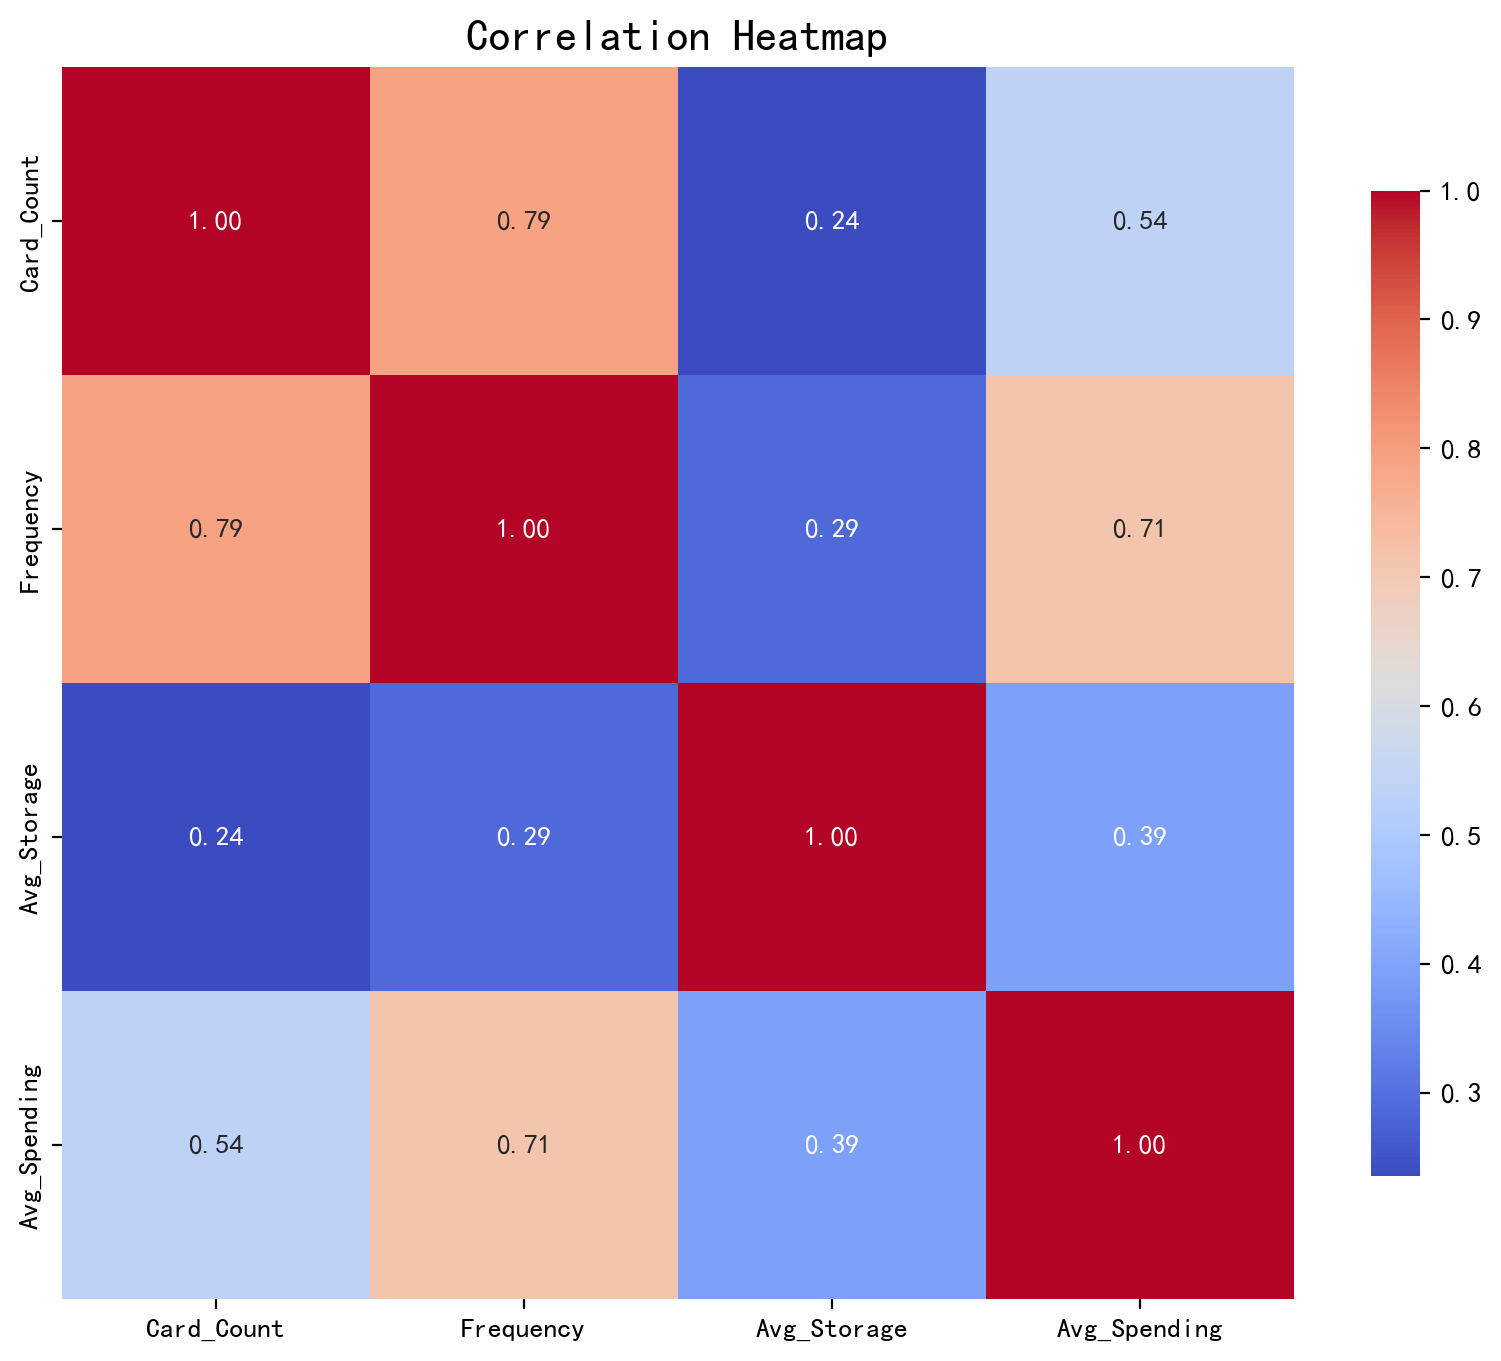

In [33]:
num_features = ['Card_Count', 'Frequency', 'Avg_Storage', 'Avg_Spending']  # 需要标准化的数值特征  

correlation_matrix = features[num_features].corr()  

# 设置画布大小  
plt.figure(figsize=(10, 8))  

# 绘制热力图  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})  

# 添加标题  
plt.title('Correlation Heatmap', fontsize=16)  
plt.show()  

In [34]:
from sklearn.preprocessing import MinMaxScaler  

# 创建 MinMaxScaler 实例  
scaler = MinMaxScaler()  

# 对数值特征进行标准化  
features[num_features] = scaler.fit_transform(features[num_features])  
# 删除cardNo为183835的异常值
features = features[features.index != 183835]  
features.head()

,Sex,Major,Card_Count,Frequency,Most_Frequent_Place,Avg_Storage,Avg_Spending
CardNo,,,,,,,
180001,男,18国际金融,0.116118,0.096875,第四食堂,0.049156,0.054262
180002,男,18国际金融,0.147314,0.140625,第一食堂,0.128180,0.042562
180004,男,18国际金融,0.478914,0.296875,第五食堂,0.126741,0.192236
180005,男,18国际金融,0.392259,0.106250,第五食堂,0.157773,0.062162
180006,男,18国际金融,0.231658,0.068750,第五食堂,0.079520,0.028745


In [35]:
from kmodes.kprototypes import KPrototypes  
import multiprocessing  
from sklearn.preprocessing import StandardScaler  

def TrainCluster(df, cate_index, model_name=None, start_k=2, end_k=20):  
    print('training cluster')  
    # 如果需要，可以进行数据标准化  
    # df = StandardScaler().fit_transform(df)   
    K = []  
    SSE = []  
    models = []  # 保存每次的模型  
    for i in range(start_k, end_k):  
        kproto_model = KPrototypes(n_clusters=i, n_jobs=multiprocessing.cpu_count())  
        try:  
            kproto_model.fit(df, categorical=cate_index)  
            SSE.append(kproto_model.cost_)  # 保存每一个k值的SSE值  
            K.append(i)  
            print('{}-prototypes SSE loss = {}'.format(i, kproto_model.cost_))  
            models.append(kproto_model)  # 保存每个k值对应的模型  
        except Exception as e:  
            print(f"Error occurred for k={i}: {e}")  

    return K, SSE, models

training cluster


2-prototypes SSE loss = 344.14776953750766
3-prototypes SSE loss = 299.71578461403413
4-prototypes SSE loss = 273.8977907726584
5-prototypes SSE loss = 257.239574513329
6-prototypes SSE loss = 250.54890506655764
7-prototypes SSE loss = 240.77670318395118
8-prototypes SSE loss = 232.61308628383935
9-prototypes SSE loss = 228.0426893781202
10-prototypes SSE loss = 220.44416080782125
11-prototypes SSE loss = 217.01146824083725
12-prototypes SSE loss = 211.40473985302796
13-prototypes SSE loss = 203.5021945374615
14-prototypes SSE loss = 199.94680326041995
15-prototypes SSE loss = 198.1391500541317
16-prototypes SSE loss = 195.0745726322044
17-prototypes SSE loss = 189.92445592764207
18-prototypes SSE loss = 188.61431868787625
19-prototypes SSE loss = 186.9861708976279


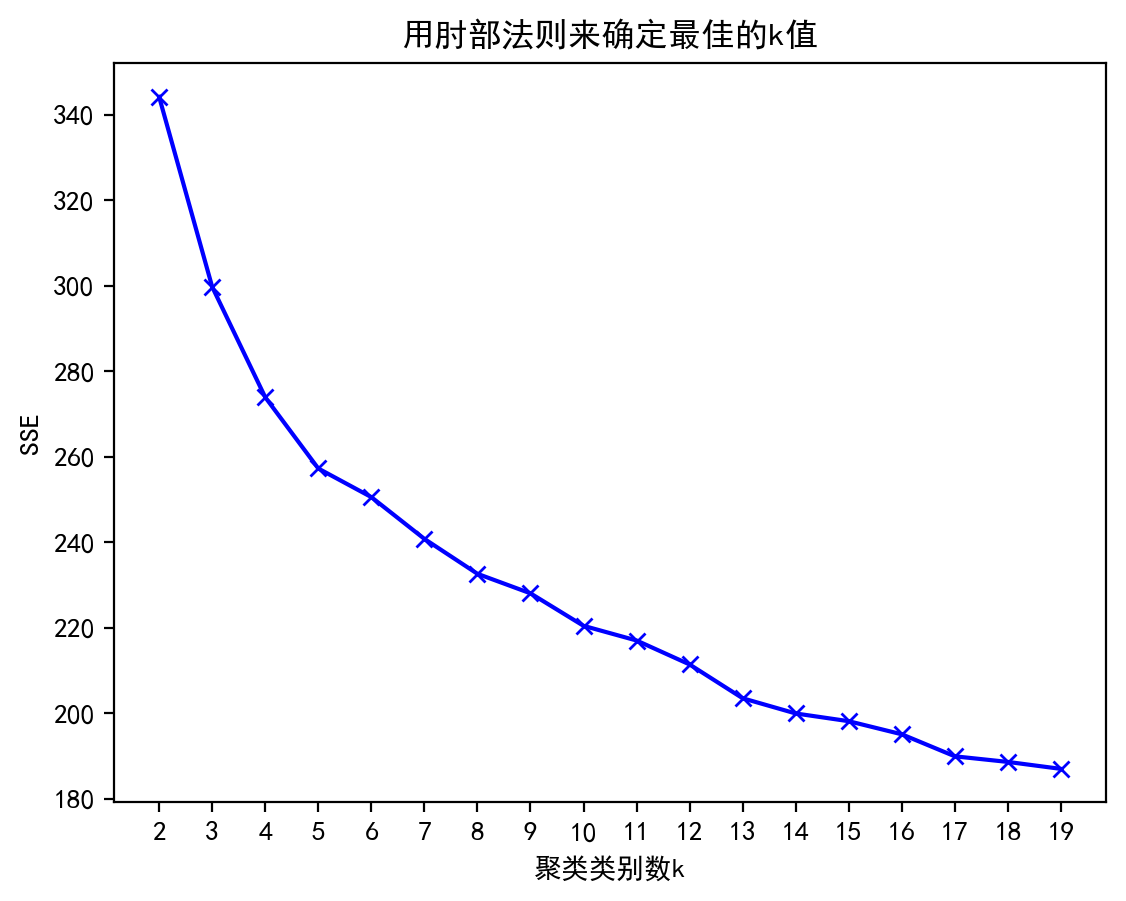

In [36]:
#用肘部法则来确定最佳的K值
cate_index = [ 0, 1, 4 ]

# 训练聚类  
train_cluster_res = TrainCluster(features, cate_index=cate_index, model_name=None, start_k=2, end_k=20)  

K = train_cluster_res[0]  
SSE = train_cluster_res[1]  

# 绘制 SSE 与 k 的关系图  
plt.plot(K, SSE, 'bx-')  
plt.xlabel('聚类类别数k')  
plt.ylabel('SSE')  
plt.xticks(K)  
plt.title('用肘部法则来确定最佳的k值')  
plt.show()  


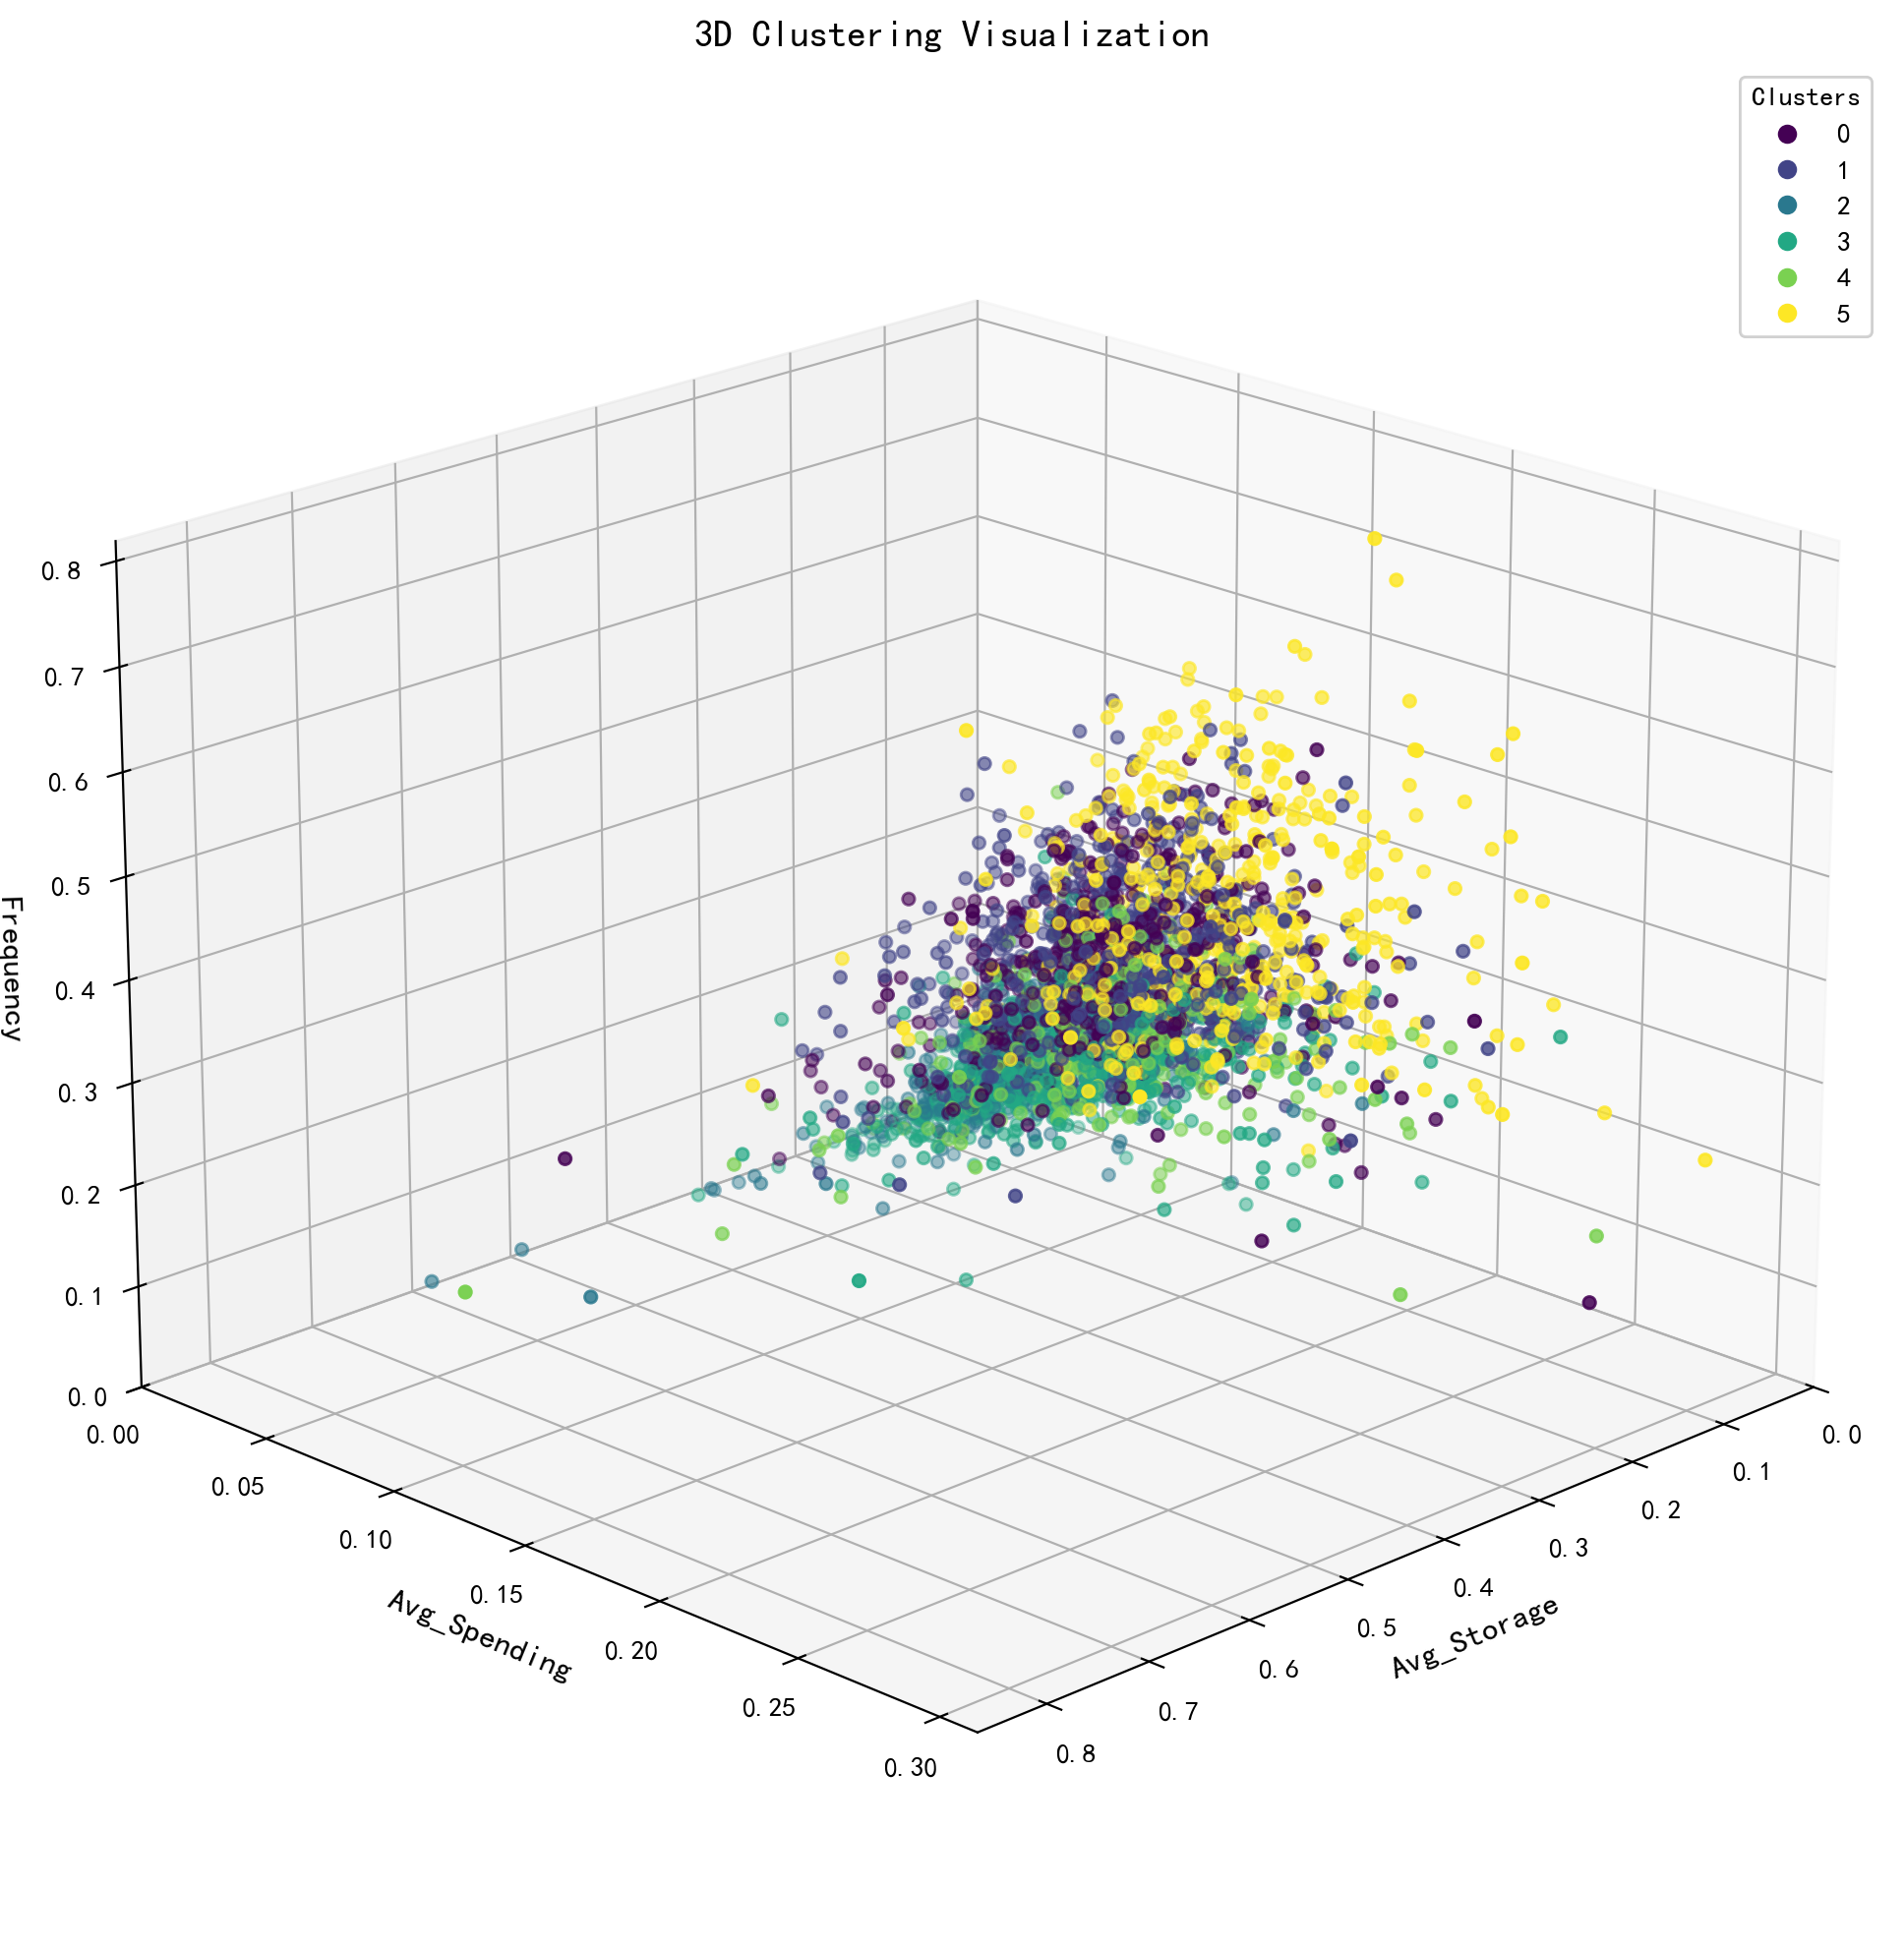

In [40]:
import matplotlib.pyplot as plt  
from mpl_toolkits.mplot3d import Axes3D  

# 选择最佳的 k 值，假设 k=6  
best_k = 6
best_model = train_cluster_res[2][best_k - 2]  # 获取模型对应的索引  

# 提取聚类标签  
final_labels = best_model.predict(features, categorical=cate_index)  

# 三维可视化  
fig = plt.figure(figsize=(12, 10))  # 设置画布大小，宽12，高10  
ax = fig.add_subplot(111, projection='3d')  

# 选择要绘制的特征  
z = features.iloc[:, 3]  # 特征3  
x = features.iloc[:, 5]  # 特征5  
y = features.iloc[:, 6]  # 特征6  

# 绘制散点图  
scatter = ax.scatter(x, y, z, c=final_labels, cmap='viridis', s=20)  # s 控制点的大小  

# 设置坐标轴标签和标题  
ax.set_zlabel('Frequency', fontsize=12)  
ax.set_xlabel('Avg_Storage', fontsize=12)  
ax.set_ylabel('Avg_Spending', fontsize=12)  
ax.set_title('3D Clustering Visualization', fontsize=14)  

# 坐标轴范围设置（可选）  
ax.set_xlim(min(x), max(x))  
ax.set_ylim(min(y), max(y))  
ax.set_zlim(min(z), max(z))  

# 设置视角，elev：仰角，azim：方位角  
ax.view_init(elev=20, azim=45)  # 你可以根据需要调整这两个值  

# 添加颜色条  
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")  
ax.add_artist(legend1)  

# 调整图形布局  
plt.tight_layout()  

plt.show()